# Сборный проект  3-4.

**Заказчик** этого исследования — каршеринговая компания.<br><br>
**Цель проекта:**
- создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения. Под риском понимается вероятность ДТП с любым повреждением транспортного средства.

**Описание данных:**<br>
данные лежат в БД.
Данные содержатся в таблицах: collisions (общая информация о ДТП), parties (информация об участниках ДТП), vehicles (информация о пострадавших машинах).

**План работ:**<br>
- загрузить данные
- предобработать данные: преобразовать типы, заполнить пропуски, обработать дубликаты.
- провести статистический анализ факторов ДТП.
- создать модель для оценки водительского риска.
- найти лучшую модель и проверить ее в работе.
- проанализировать важность признаков в выбранной модели.

## Подключитесь к базе. Загрузите таблицы sql

In [577]:
!pip install sqlalchemy -q
!pip install jupysql sqlalchemy-redshift redshift-connector 'sqlalchemy<2' -q
!pip install phik -q
!pip install shap -q

In [578]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import phik
import seaborn as sns
from sqlalchemy import create_engine, MetaData, Table
from sqlalchemy.engine import URL
from sklearn.model_selection import train_test_split

# загружаем класс pipeline
from sklearn.pipeline import Pipeline

# загружаем классы для подготовки данных
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.compose import ColumnTransformer

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем функцию для работы с метриками
from sklearn.metrics import roc_auc_score

# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

# загружаем нужные модели
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
import shap

In [579]:
db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-vehicle-db' # название базы данных,
} 

In [580]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
) 

In [581]:
engine = create_engine(connection_string)

In [582]:
query_collisions = '''
SELECT *
FROM collisions
LIMIT 5
'''

In [583]:
query_parties = '''
SELECT *
FROM parties
LIMIT 5
'''

In [584]:
query_vehicles = '''
SELECT *
FROM vehicles
LIMIT 5
'''

In [585]:
query_case = '''
SELECT *
FROM case_ids
LIMIT 5
'''

In [586]:
collisions_df = pd.read_sql_query(query_collisions, con = engine) 
parties_df = pd.read_sql_query(query_parties, con = engine) 
vehicles_df = pd.read_sql_query(query_vehicles, con = engine) 
case_df = pd.read_sql_query(query_case, con = engine) 

In [587]:
collisions_df.head()

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00


In [588]:
parties_df.head()

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0


In [589]:
vehicles_df.head()

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3
1,1,3858022,1,sedan,auto,3
2,1175712,5305030,1,sedan,auto,3
3,1175717,5305033,3,sedan,auto,5
4,1175722,5305034,2,sedan,auto,5


In [590]:
case_df.head()

,case_id,db_year
0,0081715,2021
1,0726202,2021
2,3858022,2021
3,3899441,2021
4,3899442,2021


## Проведите первичное исследование таблиц

Посмотрим, какие таблицы присутствуют в ДБ data-science-vehicle-db в схеме public.

In [591]:
query_tables = '''
SELECT table_name
FROM information_schema.tables 
WHERE table_schema = 'public'
'''


In [592]:
tables_df = pd.read_sql_query(query_tables, con = engine) 
print(tables_df)

   table_name
0    case_ids
1  collisions
2     parties
3    vehicles


Нашли 4 таблицы в схеме public: collisions, parties, vehicles, case_ids. Это соответствует условиям задачи и ER-диаграмме. Присутсвует 4 таблица case_ids с id и годом ДБ.<br>
Проверим, во всех ли таблицах есть данные. Для этого посчитаем количество строк в разных таблицах.

In [593]:
query_count = '''
SELECT 'collisions' as name ,count(*)
FROM collisions
UNION ALL
SELECT 'parties' as name ,count(*)
FROM parties
UNION ALL
SELECT 'vehicles' as name ,count(*)
FROM vehicles
UNION ALL
SELECT 'case_ids' as name ,count(*)
FROM case_ids
'''

In [594]:
count_df = pd.read_sql_query(query_count, con = engine) 

In [595]:
print(count_df)

         name    count
0    vehicles  1021234
1    case_ids  1400000
2  collisions  1400000
3     parties  2752408


In [596]:
# Загрузка метаданных
metadata = MetaData()
metadata.reflect(bind=engine)


Напишем функцию определения внешних ключей в таблице

In [597]:
def foreign_keys(table_name):
# Получение таблицы из метаданных
    table = metadata.tables[table_name]

    # Вывод информации о внешних ключах
    foreign_keys = [
        {
            "column": fk.parent.name,  # Имя столбца с внешним ключом
            "referenced_table": fk.target_fullname.split('.')[0],  # Имя ссылаемой таблицы
            "referenced_column": fk.target_fullname.split('.')[1]  # Имя ссылаемого столбца
        }
        for fk in table.foreign_keys
    ]

    # Вывод внешних ключей
    for fk in foreign_keys:
        print(f"Внешний ключ для таблицы {table_name}: {fk['column']} -> {fk['referenced_table']}.{fk['referenced_column']}")

In [598]:
tables = ['collisions', 'parties', 'vehicles', 'case_ids']

In [599]:
for table in tables:
    foreign_keys(table)

Внешний ключ для таблицы collisions: case_id -> case_ids.case_id
Внешний ключ для таблицы parties: case_id -> case_ids.case_id
Внешний ключ для таблицы vehicles: case_id -> case_ids.case_id


In [600]:
#посчитали количество уникальных case_id и количество строк всего, чтобы понять, уникальны ли значения в столбце case_id
query_count_unique = '''
SELECT 'collisions' as name ,count(DISTINCT case_id) AS cnt_case_id, count(*) AS cnt_all
FROM collisions
UNION ALL
SELECT 'parties' as name ,count(DISTINCT case_id), count(*)
FROM parties
UNION ALL
SELECT 'vehicles' as name ,count(DISTINCT case_id), count(*)
FROM vehicles
'''

In [601]:
count_unique_df = pd.read_sql_query(query_count_unique, con = engine) 

In [602]:
count_unique_df

,name,cnt_case_id,cnt_all
0,vehicles,792642,1021234
1,collisions,1400000,1400000
2,parties,1400000,2752408


Таблица **collisions** — общая информация о ДТП: <br>
Имеет уникальный case_id. Эта таблица описывает общую информацию о ДТП. Например, где оно произошло и когда.<br>

Таблица **parties** — информация об участниках ДТП<br>
Имеет неуникальный case_id, который сопоставляется с соответствующим ДТП в таблице collisions. Каждая строка здесь описывает одну из сторон, участвующих в ДТП. Если столкнулись две машины, в этой таблице должно быть две строки с совпадением case_id. Если нужен уникальный идентификатор, это case_id and party_number.<br>

Таблица **vehicles** — информация о пострадавших машинах<br>
Имеет неуникальные case_id и неуникальные party_number, которые сопоставляются с таблицей collisions и таблицей parties. Если нужен уникальный идентификатор, это case_id and party_number.

##  Проведите статистический анализ факторов ДТП

### Анализ количества аварий

In [603]:
query_count_collisions = '''
SELECT CAST (EXTRACT(MONTH FROM collision_date) AS INT) AS month, COUNT(case_id)
FROM collisions
GROUP BY month
'''

In [604]:
collisions_count_df = pd.read_sql_query(query_count_collisions, con = engine) 

In [605]:
collisions_count_df

,month,count
0,1,132044
1,2,128858
2,3,139581
3,4,130180
4,5,130316
5,6,102594
6,7,102227
7,8,104089
8,9,105159
9,10,112237


In [606]:
# функция построения графика количества аварий по месяцам
def plot_month_count(data, title): 
    # Настройка стиля графика
    sns.set_theme(style="whitegrid")  # Стиль графика

    # Создание фигуры
    plt.figure(figsize=(10, 6))

    # Линейный график
    sns.lineplot(data=data, x="month", y="count", marker="o", color="blue")
    # Обеспечение отображения всех значений на оси X
    shifted_labels = data["month"]
    plt.xticks(ticks=range(1, len(data["month"])+1), labels=shifted_labels, fontsize=12)
    plt.yticks(fontsize=12)

    # Добавление заголовка и подписей
    plt.title(title, fontsize=16)
    plt.xlabel("Месяц", fontsize=14)
    plt.ylabel("Количество", fontsize=14)

    # Отображение графика
    #plt.tight_layout()
    plt.show()

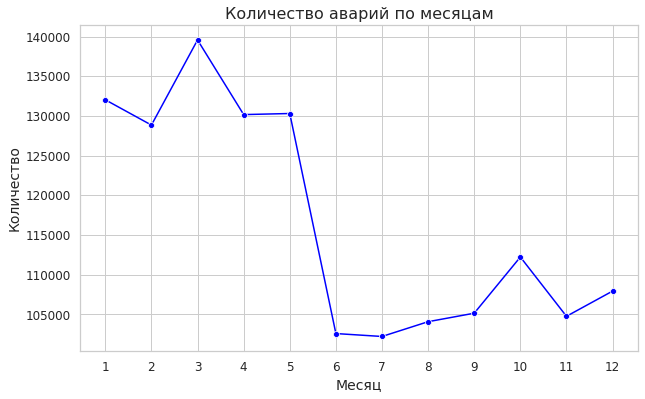

In [607]:
plot_month_count(collisions_count_df, "Количество аварий по месяцам")

Пик аварий приходится на март. Также много аварий происходит с января по май. Меньше всего аварий в летние месяцы.<br>
Проверим сильный спад в количестве аварий, начиная с 6 месяца. Возможно, есть пробелы или неточности в данных.<br>
Для этого посчитаем количество аварий за каждый месяц по каждому году отдельно.

In [608]:
query_count_collisions = '''
SELECT CAST(DATE_TRUNC('month', collision_date) AS date) AS month, COUNT(case_id)
FROM collisions
GROUP BY month
'''

In [609]:
collisions_count_df = pd.read_sql_query(query_count_collisions, con = engine) 

In [610]:
collisions_count_df

,month,count
0,2009-01-01,35062
1,2009-02-01,34480
2,2009-03-01,36648
3,2009-04-01,35239
4,2009-05-01,36916
5,2009-06-01,34202
6,2009-07-01,35161
7,2009-08-01,34508
8,2009-09-01,35555
9,2009-10-01,37835


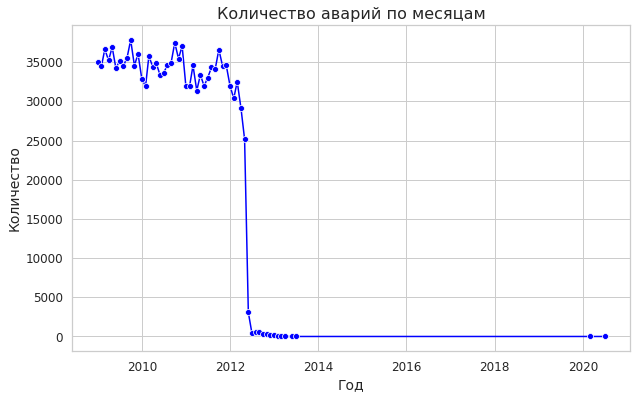

In [611]:
# Настройка стиля графика
sns.set_theme(style="whitegrid")  # Стиль графика

# Создание фигуры
plt.figure(figsize=(10, 6))

# Линейный график
sns.lineplot(data=collisions_count_df, x="month", y="count", marker="o", color="blue")
# Обеспечение отображения всех значений на оси X
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Добавление заголовка и подписей
plt.title("Количество аварий по месяцам", fontsize=16)
plt.xlabel("Год", fontsize=14)
plt.ylabel("Количество", fontsize=14)

# Отображение графика
#plt.tight_layout()
plt.show()

Начиная с июня 2012 года данных значительно меньше. В связи с этим возьмем для анализа количества аварий по месяцам данные до 2012 года.

In [612]:
query_count_collisions_before12 = '''
SELECT CAST (EXTRACT(MONTH FROM collision_date) AS INT) AS month, COUNT(case_id)
FROM collisions
WHERE collision_date < '2012-01-01'
GROUP BY month
'''

In [613]:
collisions_count_before12_df = pd.read_sql_query(query_count_collisions_before12, con = engine) 

In [614]:
collisions_count_before12_df

,month,count
0,1,99880
1,2,98373
2,3,107036
3,4,101032
4,5,105148
5,6,99531
6,7,101835
7,8,103467
8,9,104649
9,10,111933


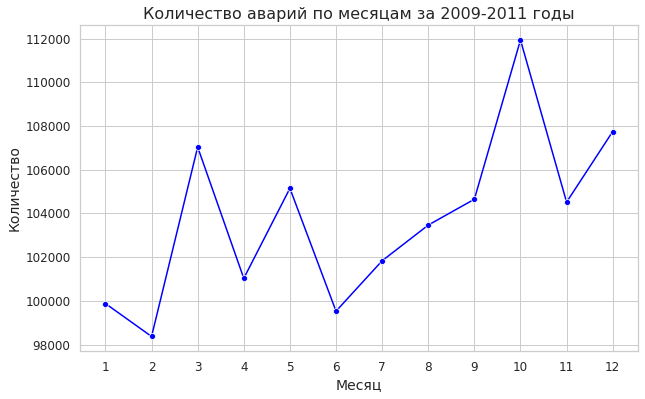

In [615]:
plot_month_count(collisions_count_before12_df, "Количество аварий по месяцам за 2009-2011 годы")

Получили более реальную картину. Пики аварий приходятся на октябрь,  март и декабрь.<br>
Сильный всплеск значений в октябре возможно связан с первым снегом, гололедом на дорогах, когда не все участники движения успели переобуться.

### Задачи для совещания рабочей группы

1. Выясните, в какое время суток происходит больше всего аварий.<br>
2. Проанализируйте, какие типы аварий бывают. Какую часть от всех происшествий на дороге составляют серьезные происшествия, а какую часть царапины, мелкие повреждения?<br>
3. При каких погодных условиях чаще всего возникают ДТП? Влияет ли погода на серьезность повреждения транспортного средства?<br>
4. Несет ли риск вождение "возрастного автомобиля"?<br>
5. Какая доля аварий происходит из-за использования телефона?<br>
6. Выяснить географию аварий: в каких странах, на каких типах дорог чаще всего происходят ДТП?

#### Несет ли риск вождение "возрастного автомобиля"?

План работ:<br>
    - Создайте sql-запрос: разбейте машины на категории по возрастам, проанализируйте степени повреждения в авариях<br>
    - Постройте график<br>
    - Сделайте вывод<br>

Разобьем машины на группы по возрасту.<br>
Посчитаем количество аварий в разрезе возрастных групп и степени серьезности ДТП.

In [616]:
query_vehicle_age = '''
WITH v AS (
--разобьем машины на группы по возрасту
SELECT vehicle_age, case_id, 
CASE WHEN vehicle_age < 4 THEN '0-3' 
     WHEN vehicle_age < 8 THEN '4-7'
     WHEN vehicle_age < 11 THEN '8-10'
     WHEN vehicle_age < 16 THEN '11-15'
     ELSE '>15' END 
     AS age_group 
FROM vehicles
WHERE vehicle_age>0
)
--посчитаем количество аварий в разрезе возрастных групп и степени серьезности ДТП
SELECT c.collision_damage, v.age_group, count(c.case_id) AS cnt
FROM collisions c
JOIN v ON c.case_id = v.case_id
GROUP BY c.collision_damage, v.age_group
ORDER BY c.collision_damage, cnt DESC, age_group
'''

In [617]:
vehicle_age_df = pd.read_sql_query(query_vehicle_age, con = engine) 

In [618]:
vehicle_age_df

,collision_damage,age_group,cnt
0,fatal,4-7,6048
1,fatal,0-3,3533
2,fatal,8-10,3482
3,fatal,11-15,1701
4,fatal,>15,22
5,middle damage,4-7,87891
6,middle damage,0-3,74013
7,middle damage,8-10,36983
8,middle damage,11-15,13744
9,middle damage,>15,26


Посчитаем относительный показатель в процентах: учтем, какое количество машин в каждой возрастной группе.

In [619]:
query_vehicle_age = '''
WITH v AS (
--разобьем машины на группы по возрасту
    SELECT 
        vehicle_age, 
        case_id,
        CASE 
            WHEN vehicle_age < 4 THEN '0-3' 
            WHEN vehicle_age < 8 THEN '4-7'
            WHEN vehicle_age < 11 THEN '8-10'
            WHEN vehicle_age < 16 THEN '11-15'
            ELSE '>15' 
        END AS age_group 
    FROM vehicles
    WHERE vehicle_age > 0
),
-- посчитаем количество машин в кажой группе
cnt_vehicles AS (
SELECT v.age_group, count(case_id) AS cnt_veh
FROM v
GROUP BY v.age_group)
SELECT c.collision_damage, --степень повреждения
v.age_group, --возраст машины
count(c.case_id) AS cnt, --количество аварий
cv.cnt_veh, --количество машин в данной группе
round(count(c.case_id)*100.0/cv.cnt_veh,2) as cnt_prc --процент машин из данной возрастной группы, получивших такую степень повреждения
FROM collisions c
JOIN v ON c.case_id = v.case_id
JOIN  cnt_vehicles cv ON v.age_group = cv.age_group
GROUP BY c.collision_damage, v.age_group, cv.cnt_veh
ORDER BY c.collision_damage, cnt_prc DESC, age_group
'''

In [620]:
vehicle_age_df = pd.read_sql_query(query_vehicle_age, con = engine) 

In [621]:
vehicle_age_df

,collision_damage,age_group,cnt,cnt_veh,cnt_prc
0,fatal,>15,22,153,14.38
1,fatal,11-15,1701,56917,2.99
2,fatal,8-10,3482,173782,2.00
3,fatal,4-7,6048,399151,1.52
4,fatal,0-3,3533,326387,1.08
5,middle damage,11-15,13744,56917,24.15
6,middle damage,0-3,74013,326387,22.68
7,middle damage,4-7,87891,399151,22.02
8,middle damage,8-10,36983,173782,21.28
9,middle damage,>15,26,153,16.99


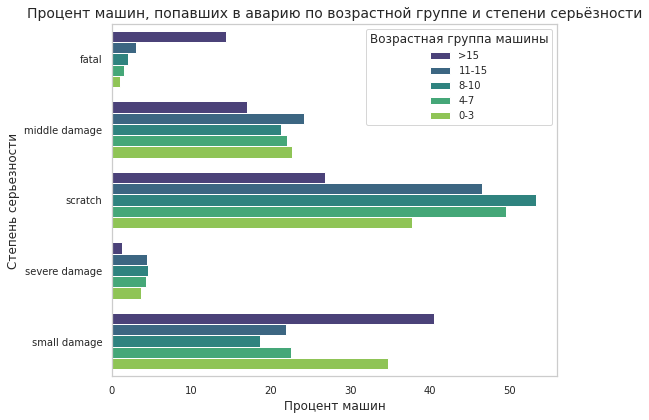

In [622]:
plt.figure(figsize=(8, 6))
sns.barplot(
    data=vehicle_age_df, 
    y='collision_damage',  # Возрастная группа на оси Y
    x='cnt_prc',   # Проценты на оси X
    hue='age_group', 
    palette='viridis'
)

# Подписи
plt.title('Процент машин, попавших в аварию по возрастной группе и степени серьёзности', fontsize=14)
plt.ylabel('Степень серьезности', fontsize=12)
plt.xlabel('Процент машин', fontsize=12)
plt.legend(title='Возрастная группа машины', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Отображение графика
plt.tight_layout()
plt.show()

По графику видно, что самая большая доля фатальных повреждений приходится на возрастные автомобили, которым более 15 лет.<br>
Т.е. определенный риск есть.<br>
Также большая доля "малых повреждений".<br>
У машин в категории 11-15 лет самая большая доля средних повреждений.<br>
Зато "царапину" регистрирует довольно малая доля возрастных машин.

#### Какая доля аварий происходит из-за использования телефона?

План работ:<br>
    - Создайте sql-запрос: отберите виновных в ДТП, посчитайте долю виновных, использовавших телефон<br>
    - Постройте график<br>
    - Сделайте вывод<br>

In [623]:
query_telephone = '''
SELECT count(c.case_id), --общее количество аварий
       sum(cellphone_in_use), --количество использовавших телефон за рулем
       round(sum(cellphone_in_use)*100.0/count(c.case_id),2) as pers_telephone, --доля аварий с использованием телефона
       round(100 - sum(cellphone_in_use)*100.0/count(c.case_id),2) as pers_other --доля аварий по другим причинам
FROM collisions c
JOIN parties p ON c.case_id = p. case_id AND p.at_fault = 1 --отобрали виновных в аварии
'''

In [624]:
telephone_df = pd.read_sql_query(query_telephone, con = engine) 

In [625]:
telephone_df

,count,sum,pers_telephone,pers_other
0,1288127,24772,1.92,98.08


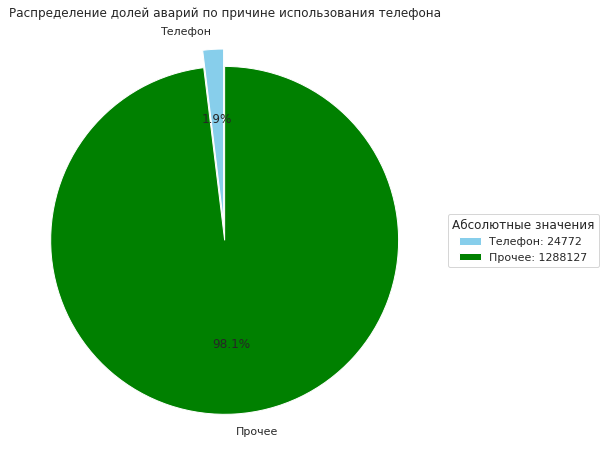

In [626]:
# Данные
labels = ['Телефон', 'Прочее']
sizes = [telephone_df['pers_telephone'][0], telephone_df['pers_other'][0]]
abs_sizes = [telephone_df['sum'][0], telephone_df['count'][0]]
colors=['skyblue', 'green']
# Построение круговой диаграммы
plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(
    sizes, 
    labels=labels, 
    autopct='%1.1f%%',  # Процент на диаграмме
    startangle=90, 
    colors=colors, 
    explode=(0.1, 0)  # Выделение сектора
)
# Добавление легенды с абсолютными значениями
absolute_labels = [f'{label}: {size}' for label, size in zip(labels, abs_sizes)]
plt.legend(wedges, absolute_labels, title="Абсолютные значения", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.title("Распределение долей аварий по причине использования телефона")
plt.show()

По причине использования телфона возникает около 2% аварий. В процентном соотношении кажется не таким большим значением, но в абсолютном получилось около 25 тыс. аварий.<br>
Что подтверждает правило, что нельзя использовать телефон за рулем.

## Проведите анализ важности факторов ДТП

### Создайте модель для оценки водительского риска

Подготовим набор данных на основе первичного предположения заказчика:<br>
    - Выберите тип виновника — только машина (car).<br>
    - Возьмите случаи, когда ДТП привело к любым значимым повреждениям автомобиля любого из участников — все, кроме типа SCRATCH (царапина).<br>
    - Для моделирования возьмите данные только за 2012 год.

In [627]:
query_factors = '''
SELECT p.*, v.vehicle_age, v.vehicle_type, v.vehicle_transmission, c.weather_1, c.road_surface, c.lighting, c.county_city_location, c.location_type, c.road_condition_1, c.control_device, c.distance
FROM collisions c 
JOIN parties p ON c.case_id = p.case_id
JOIN vehicles v ON c.case_id = v.case_id AND p.party_number = v.party_number
WHERE party_type = 'car' --тип виновника — только машина (car)
      AND c.collision_damage != 'scratch' --случаи, когда ДТП привело к любым значимым повреждениям автомобиля любого из участников — все, кроме типа SCRATCH (царапина)
      AND EXTRACT(year FROM collision_date) = 2012 --данные только за 2012 год
      AND v.vehicle_age <= 10 --машины не старше 10 лет
'''

In [628]:
factors_df = pd.read_sql_query(query_factors, con = engine) 

In [629]:
factors_df

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use,vehicle_age,vehicle_type,vehicle_transmission,weather_1,road_surface,lighting,county_city_location,location_type,road_condition_1,control_device,distance
0,2672478,5608536,1,car,1,33.0,had not been drinking,None,0.0,0,sedan,auto,raining,wet,daylight,4900,highway,normal,none,528.0
1,2657345,5599684,2,car,0,46.0,had not been drinking,None,0.0,2,sedan,auto,clear,dry,daylight,1942,None,normal,functioning,20.0
2,2657829,5599941,1,car,1,38.0,"had been drinking, under influence",None,0.0,5,sedan,auto,clear,dry,dark with no street lights,4100,intersection,other,none,40.0
3,2453122,5479989,2,car,0,35.0,had not been drinking,None,0.0,1,sedan,manual,clear,dry,daylight,1200,None,normal,none,0.0
4,2453185,5480024,1,car,0,42.0,had not been drinking,None,0.0,7,sedan,manual,clear,dry,daylight,1900,None,normal,none,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51408,2575854,5546026,2,car,0,23.0,impairment unknown,G,NaN,3,coupe,manual,clear,dry,dark with street lights,1942,None,normal,none,85.0
51409,2576025,5546110,1,car,1,29.0,had not been drinking,None,0.0,4,coupe,manual,clear,dry,daylight,3026,highway,normal,none,1500.0
51410,2576196,5546196,1,car,1,48.0,had not been drinking,None,0.0,7,coupe,auto,cloudy,wet,dark with no street lights,1942,None,reduced width,none,5.0
51411,2576374,5546296,2,car,0,45.0,had not been drinking,None,1.0,7,coupe,auto,clear,dry,daylight,1942,None,normal,functioning,160.0


In [630]:
factors_df.describe()

,id,party_number,at_fault,insurance_premium,cellphone_in_use,vehicle_age,distance
count,5.141300e+04,51413.000000,51413.000000,51002.000000,47485.000000,51413.000000,5.141300e+04
mean,2.594827e+06,1.528582,0.504833,35.692600,0.020491,4.416354,8.751382e+02
std,9.868998e+04,0.664643,0.499982,14.311894,0.141673,2.608277,7.528943e+03
min,1.800807e+06,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,2.517805e+06,1.000000,0.000000,23.000000,0.000000,3.000000,1.000000e+01
50%,2.598747e+06,1.000000,1.000000,33.000000,0.000000,4.000000,1.470000e+02
75%,2.681122e+06,2.000000,1.000000,46.000000,0.000000,6.000000,5.820000e+02
max,2.752381e+06,9.000000,1.000000,105.000000,1.000000,10.000000,1.584000e+06


Отберем факторы. Для построения модели точно понадобятся колонки:<br>
    - party_sobriety, т.е. трезвость участника<br>
    - party_drug_physical, т.е. состояние участника: физическое или с учётом принятых лекарств<br>
    - vehicle_age, т.е. возраст автомобиля (могут быть какие-то скрытые поломки, дефекты, что-то вышло из строя)<br>
    - road_surface, т.е. состояние дороги (т.к. на скользкой дороге машину может занести и водитель не справится с управлением)<br>
Также с помощью корреляционного анализа посмотрим, какие факторы влияют на виновность в аварии.<br>
Также проверим факторы vehicle_transmission (тип КПП), insurance_premium (страховка) - это скорее фактор, как часто регистрируется ДТП, distance (расстояние от главной дороги).<br>


#### Статистическое исследование отобранных факторов

In [631]:
columns = ['at_fault', 'party_sobriety', 'party_drug_physical', 'vehicle_transmission', 'road_surface',  'vehicle_age', 'distance' , 'insurance_premium']

In [632]:
factors_df = factors_df [columns]

In [633]:
factors_df.head()

,at_fault,party_sobriety,party_drug_physical,vehicle_transmission,road_surface,vehicle_age,distance,insurance_premium
0,1,had not been drinking,None,auto,wet,0,528.0,33.0
1,0,had not been drinking,None,auto,dry,2,20.0,46.0
2,1,"had been drinking, under influence",None,auto,dry,5,40.0,38.0
3,0,had not been drinking,None,manual,dry,1,0.0,35.0
4,0,had not been drinking,None,manual,dry,7,2.0,42.0


In [634]:
factors_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51413 entries, 0 to 51412
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   at_fault              51413 non-null  int64  
 1   party_sobriety        50631 non-null  object 
 2   party_drug_physical   2550 non-null   object 
 3   vehicle_transmission  50878 non-null  object 
 4   road_surface          51107 non-null  object 
 5   vehicle_age           51413 non-null  int64  
 6   distance              51413 non-null  float64
 7   insurance_premium     51002 non-null  float64
dtypes: float64(2), int64(2), object(4)
memory usage: 3.1+ MB


In [635]:
#Проверка на пропуски в данных
factors_df.isna().sum()

at_fault                    0
party_sobriety            782
party_drug_physical     48863
vehicle_transmission      535
road_surface              306
vehicle_age                 0
distance                    0
insurance_premium         411
dtype: int64

In [636]:
# проверка на неявные дубликаты
factors_df['party_sobriety'].value_counts()

had not been drinking                     44234
had been drinking, under influence         4334
impairment unknown                         1049
had been drinking, not under influence      546
had been drinking, impairment unknown       242
not applicable                              226
Name: party_sobriety, dtype: int64

Неявных дубликатов в столбце 'party_sobriety' не обнаружено. Пока оставим категории в таком виде, но заполним пропуски.

In [637]:
factors_df.loc[:,'party_sobriety'] = factors_df.loc[:,'party_sobriety'].fillna('not applicable')

/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [638]:
factors_df['party_sobriety'].value_counts()

had not been drinking                     44234
had been drinking, under influence         4334
impairment unknown                         1049
not applicable                             1008
had been drinking, not under influence      546
had been drinking, impairment unknown       242
Name: party_sobriety, dtype: int64

In [639]:
# проверка на неявные дубликаты
factors_df['party_drug_physical'].value_counts()

G                        1049
under drug influence      819
sleepy/fatigued           361
not applicable            226
impairment - physical      95
Name: party_drug_physical, dtype: int64

В столбце 'party_drug_physical' есть неявные дубликаты. Например, G и not applicable. Объединим их в категорию not applicable.<br>
Аналогичным образом заполним отсутствующие значения.

In [640]:
factors_df.loc[:,'party_drug_physical'] = factors_df.loc[:,'party_drug_physical'].str.replace('G', 'not applicable')

In [641]:
factors_df.loc[:,'party_drug_physical'] = factors_df.loc[:,'party_drug_physical'].fillna('not applicable')

In [642]:
factors_df['party_drug_physical'].value_counts()

not applicable           50138
under drug influence       819
sleepy/fatigued            361
impairment - physical       95
Name: party_drug_physical, dtype: int64

In [643]:
factors_df['vehicle_transmission'].value_counts()

manual    27222
auto      23656
Name: vehicle_transmission, dtype: int64

In [644]:
factors_df['vehicle_transmission'] = factors_df['vehicle_transmission'].fillna('unknown')

/tmp/ipykernel_31/2682916846.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  factors_df['vehicle_transmission'] = factors_df['vehicle_transmission'].fillna('unknown')


In [645]:
factors_df['road_surface'].value_counts()

dry         45855
wet          4879
snowy         331
slippery       42
Name: road_surface, dtype: int64

In [646]:
factors_df['road_surface'] = factors_df['road_surface'].fillna('unknown')

/tmp/ipykernel_31/3515760884.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  factors_df['road_surface'] = factors_df['road_surface'].fillna('unknown')


Заполнили неизвестные категории в колонках значением unknown.

In [647]:
factors_df['vehicle_age'].value_counts()

3     11012
4      7157
2      6048
5      5565
6      3940
7      3838
8      3509
0      3087
9      2770
1      2545
10     1942
Name: vehicle_age, dtype: int64

In [648]:
factors_df.loc[:,'insurance_premium'] = factors_df.loc[:,'insurance_premium'].fillna(factors_df['insurance_premium'].median())

/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [649]:
factors_df.describe()

,at_fault,vehicle_age,distance,insurance_premium
count,51413.000000,51413.000000,5.141300e+04,51413.000000
mean,0.504833,4.416354,8.751382e+02,35.671075
std,0.499982,2.608277,7.528943e+03,14.256589
min,0.000000,0.000000,0.000000e+00,0.000000
25%,0.000000,3.000000,1.000000e+01,23.000000
50%,1.000000,4.000000,1.470000e+02,33.000000
75%,1.000000,6.000000,5.820000e+02,46.000000
max,1.000000,10.000000,1.584000e+06,105.000000


In [650]:
#Проверка на пропуски в данных
factors_df.isna().sum()

at_fault                0
party_sobriety          0
party_drug_physical     0
vehicle_transmission    0
road_surface            0
vehicle_age             0
distance                0
insurance_premium       0
dtype: int64

In [651]:
data = factors_df

#### Анализ категориальных и количественных признаков

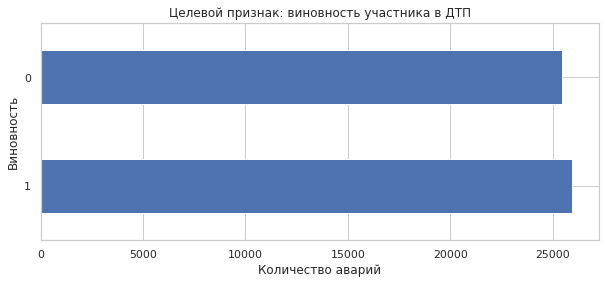

In [652]:
data['at_fault'].value_counts().plot(y='Виновность',title='Целевой признак: виновность участника в ДТП', kind='barh' , figsize = (10,4), legend = False)
plt.ylabel("Виновность");
plt.xlabel("Количество аварий");

Сильного дисбаланса в категории виновен/не виновен не наблюдаем.

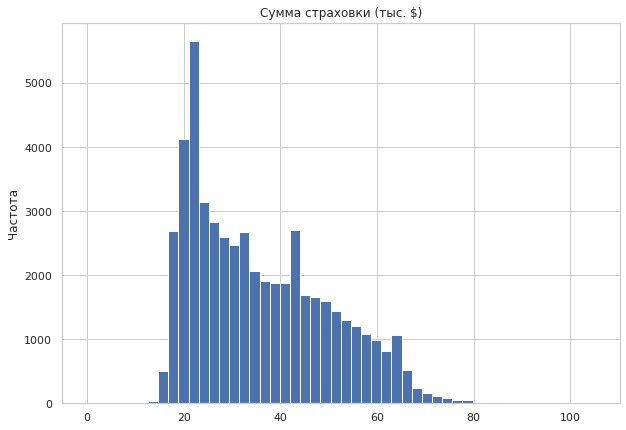

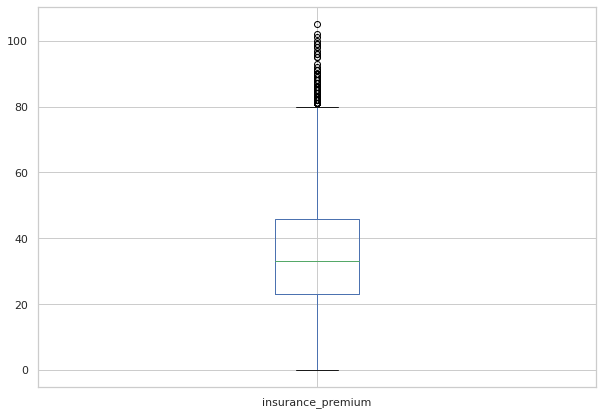

In [653]:
data.plot(y='insurance_premium',title='Сумма страховки (тыс. $)', kind='hist' ,bins=50, figsize = (10,7), legend = False)
plt.ylabel("Частота");
data.plot(y='insurance_premium', kind='box' , figsize = (10,7), legend = False);

Распределение столбца 'insurance_premium' скошено, выбросы есть, но явных аномалий не видно.<br>
Среднее значение составило 35,7 тыс. долларов, медиана  составила 33 тыс. долларов

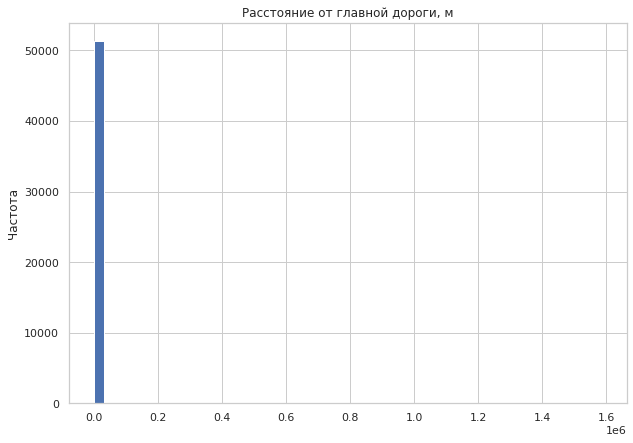

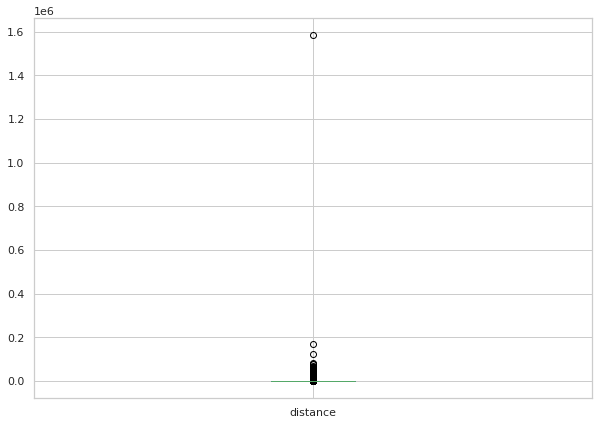

In [654]:
data.plot(y='distance',title='Расстояние от главной дороги, м', kind='hist' ,bins=50, figsize = (10,7), legend = False)
plt.ylabel("Частота");
data.plot(y='distance', kind='box' , figsize = (10,7), legend = False);

Посмотрим на выбросы внимательнее и удалим самые большие аномалии.

In [663]:
data[data['distance']>100000]

,at_fault,party_sobriety,party_drug_physical,vehicle_transmission,road_surface,vehicle_age,distance,insurance_premium


In [664]:
data = data[data['distance']<=100000]

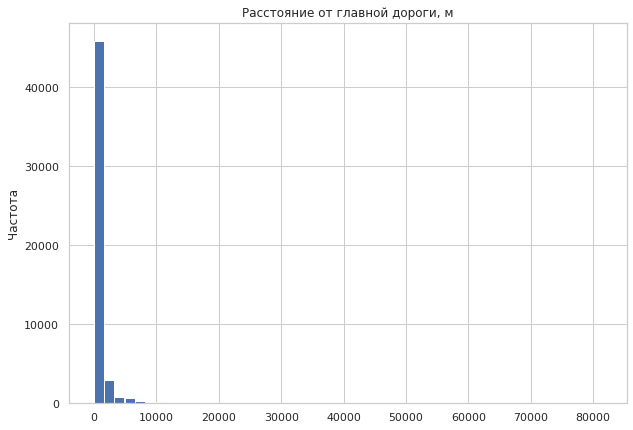

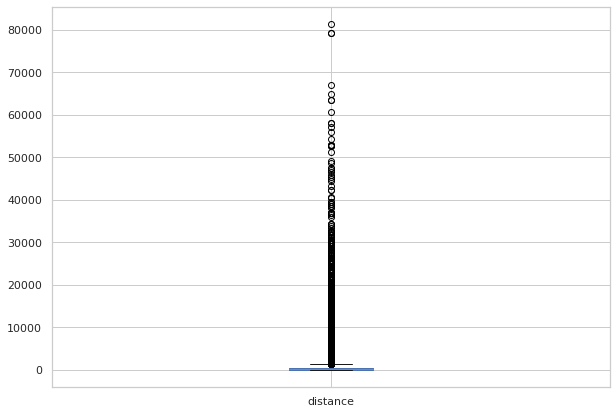

In [665]:
data.plot(y='distance',title='Расстояние от главной дороги, м', kind='hist' ,bins=50, figsize = (10,7), legend = False)
plt.ylabel("Частота");
data.plot(y='distance', kind='box' , figsize = (10,7), legend = False);

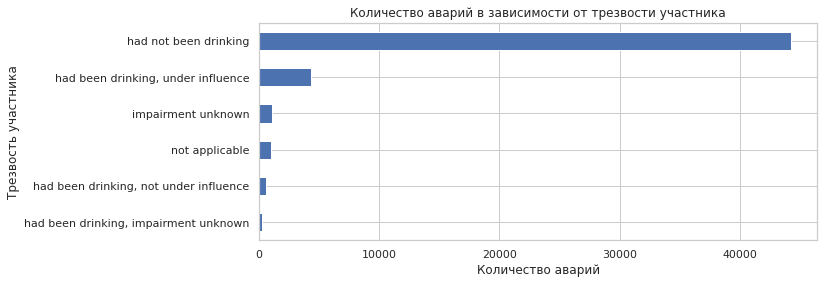

In [666]:
data.pivot_table(index = 'party_sobriety', aggfunc = 'count')['at_fault'].sort_values().plot(y='Трезвость участника',title='Количество аварий в зависимости от трезвости участника', kind='barh' , figsize = (10,4), legend = False)
plt.ylabel("Трезвость участника");
plt.xlabel("Количество аварий");

Конечно большая часть участников была в трезвом состоянии.<br>
Но довольно много, если смотреть в абсолютном значении, под влиянием средств и в нетрезвом состоянии.

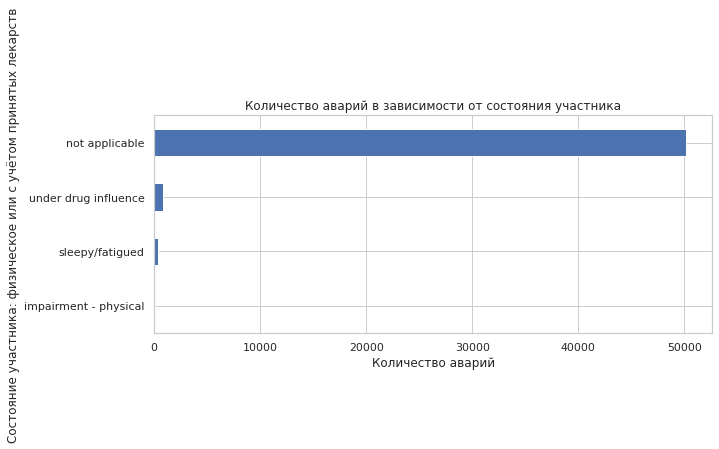

In [667]:
data.pivot_table(index = 'party_drug_physical', aggfunc = 'count')['at_fault'].sort_values().plot(y='Состояние участника',title='Количество аварий в зависимости от состояния участника', kind='barh' , figsize = (10,4), legend = False)
plt.ylabel("Состояние участника: физическое или с учётом принятых лекарств");
plt.xlabel("Количество аварий");

В столбце Состояние участника очень много пропусков, но есть и категории: под влиянием лекарств, уставший, физические нарушения

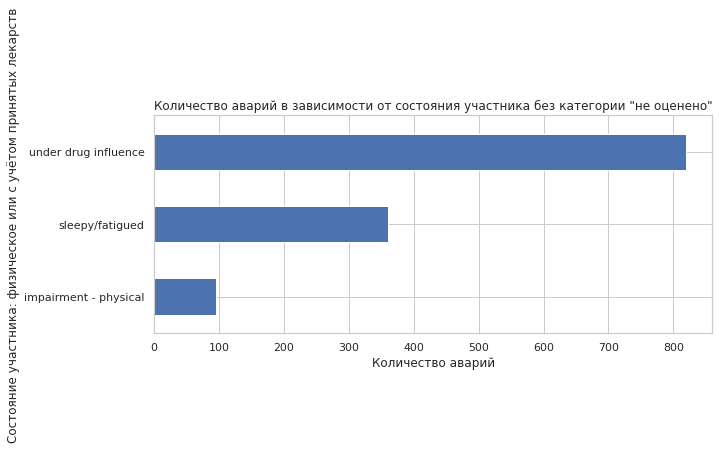

In [668]:
data[data['party_drug_physical']!='not applicable'].pivot_table(index = 'party_drug_physical', aggfunc = 'count')['at_fault'].sort_values().plot(y='Состояние участника',title='Количество аварий в зависимости от состояния участника без категории "не оценено"', kind='barh' , figsize = (10,4), legend = False)
plt.ylabel("Состояние участника: физическое или с учётом принятых лекарств");
plt.xlabel("Количество аварий");

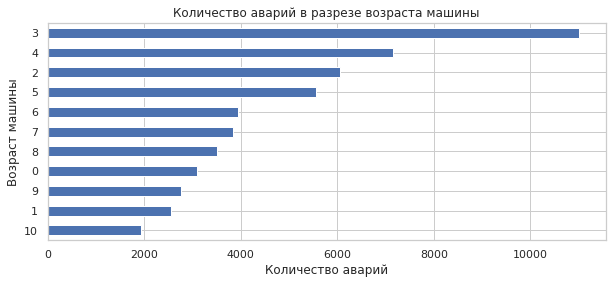

In [671]:
data['vehicle_age'].value_counts().sort_values().plot(y='Возраст',title='Количество аварий в разрезе возраста машины', kind='barh' , figsize = (10,4), legend = False)
plt.ylabel("Возраст машины");
plt.xlabel("Количество аварий");

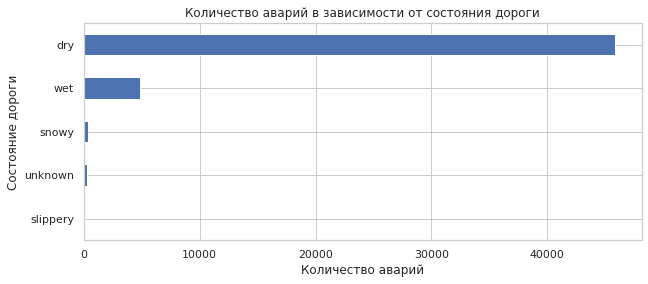

In [673]:
data['road_surface'].value_counts().sort_values().plot(y='Состояние дороги',title='Количество аварий в зависимости от состояния дороги', kind='barh' , figsize = (10,4), legend = False)
plt.ylabel("Состояние дороги");
plt.xlabel("Количество аварий");

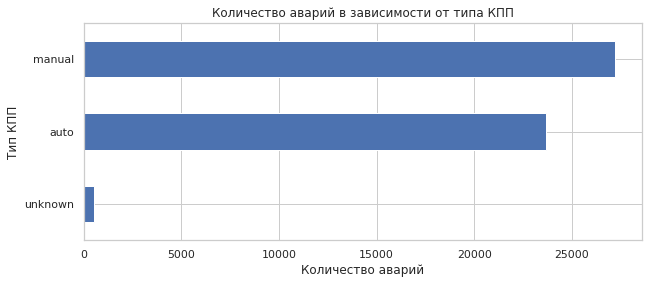

In [674]:
data['vehicle_transmission'].value_counts().sort_values().plot(y='Тип КПП',title='Количество аварий в зависимости от типа КПП', kind='barh' , figsize = (10,4), legend = False)
plt.ylabel("Тип КПП");
plt.xlabel("Количество аварий");

Чаще участвуют в авариях автомобили с ручной коробкой передач.

#### Корреляционный анализ

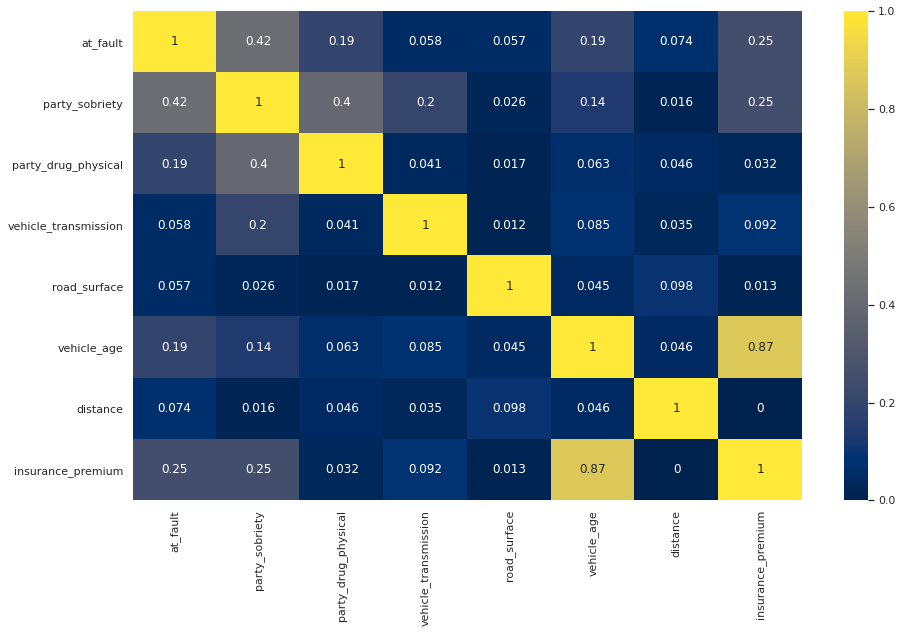

In [675]:
fig, ax = plt.subplots(figsize=(15,9));
sns.heatmap(data.phik_matrix(interval_cols = ['insuranse_premium', 'vehicle_age', 'distance']), annot=True, cmap='cividis', ax = ax);

Мультиколлинеарности не наблюдаем.<br>
Прослеживается взаимосвязь виновности в аварии и трезвости водителя, что абсолютно соответствует реальности.

#### Выбор лучшей модели

In [676]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [677]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['at_fault'], axis=1),
    data['at_fault'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = data['at_fault'])

X_train.shape, X_test.shape

((38557, 7), (12853, 7))

In [678]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38557 entries, 26702 to 3473
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   party_sobriety        38557 non-null  object 
 1   party_drug_physical   38557 non-null  object 
 2   vehicle_transmission  38557 non-null  object 
 3   road_surface          38557 non-null  object 
 4   vehicle_age           38557 non-null  int64  
 5   distance              38557 non-null  float64
 6   insurance_premium     38557 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 2.4+ MB


Кодирование целевого признака применять не нужно, т.к. он принимает значения 0 и 1.

In [679]:
# создаём списки с названиями признаков
ohe_columns = ['party_sobriety', 'party_drug_physical', 'vehicle_transmission', 'road_surface']
#ord_columns = ['Популярная_категория']
num_columns = ['insurance_premium','vehicle_age', 'distance']

In [680]:
# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False))#drop='first',
    ]
    )

# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)


Качество оцениваем метрикой **ROC_AUC**.<br>
<br>
ROC_AUC выбрали, т.к.:<br>
    - она учитывает работу модели при всех возможных значениях порогов<br>
    - объектов с одним значением целевого признака больше, чем с другими.

In [681]:
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     #('ord', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,5),
        'models__max_features': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели SVC()
    {
        'models': [SVC(
            random_state=RANDOM_STATE, probability= True
        )],
        'models__kernel': ['rbf', 'sigmoid', 'poly'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

# проверьте работу модели на тестовой выборке
# рассчитайте прогноз на тестовых данных
pred = randomized_search.predict_proba(X_test)
pred_one = pred[:,1]
y_pred = randomized_search.predict(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, pred_one)}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['party_sobriety',
                                                   'party_drug_physical',
                                                   'vehicle_transmission',
                                                   'road_surface']),
                                                 ('num'

In [682]:
# pd.set_option('display.max_colwidth', None)
result = pd.DataFrame(randomized_search.cv_results_)
display(result[
    ['rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score'));

,rank_test_score,param_models,mean_test_score,params
8,1,"LogisticRegression(C=4, penalty='l1', random_s...",0.694686,"{'preprocessor__num': StandardScaler(), 'model..."
5,2,"SVC(probability=True, random_state=42)",0.693885,"{'preprocessor__num': MinMaxScaler(), 'models_..."
4,3,KNeighborsClassifier(),0.649411,"{'preprocessor__num': MinMaxScaler(), 'models_..."
7,4,KNeighborsClassifier(),0.636368,"{'preprocessor__num': MinMaxScaler(), 'models_..."
2,5,KNeighborsClassifier(),0.634669,"{'preprocessor__num': StandardScaler(), 'model..."
6,6,KNeighborsClassifier(),0.616866,"{'preprocessor__num': StandardScaler(), 'model..."
3,7,DecisionTreeClassifier(random_state=42),0.600795,"{'preprocessor__num': MinMaxScaler(), 'models_..."
9,7,DecisionTreeClassifier(random_state=42),0.600795,"{'preprocessor__num': StandardScaler(), 'model..."
1,9,DecisionTreeClassifier(random_state=42),0.595195,"{'preprocessor__num': 'passthrough', 'models__..."
0,10,DecisionTreeClassifier(random_state=42),0.538796,"{'preprocessor__num': StandardScaler(), 'model..."


К данным применили методы масштабирования и кодирования(OneHotEncoder).<br>
Применяли модели:<br>
    - KNeighborsClassifier с параметром n_neighbors<br>
    - DecisionTreeClassifier с параметрами max_depth, max_features<br>
    - LogisticRegression с параметром C<br>
    - SVC с параметром kernel<br>
Использовали RandomizedSearchCV для подбора гиперпараметров моделей.<br>
<br>
Качество оценивали метрикой ROC_AUC.<br>
<br>
ROC_AUC выбрали, т.к.:<br>
    - она учитывает работу модели при всех возможных значениях порогов<br>
    - объектов с одним значением целевого признака больше, чем с другими.

Наилучшей оказалась модель **логистической регрессии** с параметрами: C=4 и penalty=l1.

#### Проверка лучшей модели в работе

Построим график Матрица ошибок.

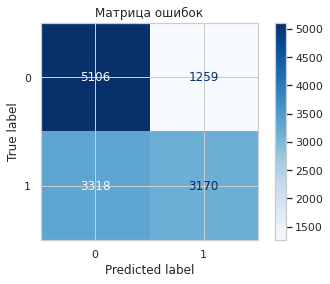

In [683]:
conf_matrix = confusion_matrix(y_test, y_pred)
best_model = randomized_search.best_estimator_
# Визуализация матрицы ошибок
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_model.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Матрица ошибок')
plt.show()

Матрица ошибок учитывает все предсказанные значения.<br>
Есть и ошибки первого рода, и второго.

Проведем анализ важности признаков

In [684]:
feature_names = randomized_search.best_estimator_.named_steps['preprocessor'].transformers_[0][1].named_steps['ohe'].get_feature_names().tolist()+num_columns

In [685]:
print(feature_names)

['x0_had been drinking, impairment unknown', 'x0_had been drinking, not under influence', 'x0_had been drinking, under influence', 'x0_had not been drinking', 'x0_impairment unknown', 'x0_not applicable', 'x1_impairment - physical', 'x1_not applicable', 'x1_sleepy/fatigued', 'x1_under drug influence', 'x2_auto', 'x2_manual', 'x2_unknown', 'x3_dry', 'x3_slippery', 'x3_snowy', 'x3_unknown', 'x3_wet', 'insurance_premium', 'vehicle_age', 'distance']


In [686]:
data_preprocessor.fit(X_train, y_train)
X_train_p = pd.DataFrame(data_preprocessor.transform(X_train), columns = feature_names)
# выводим предсказанные значения тренировочной выборки
X_test_p = pd.DataFrame(data_preprocessor.transform(X_test), columns = feature_names)

In [687]:
randomized_search.best_estimator_.named_steps['models'].fit(X_train_p, y_train)

LogisticRegression(C=4, penalty='l1', random_state=42, solver='liblinear')

Оценим вклад признаков модели с помощью функции permutation_importance.

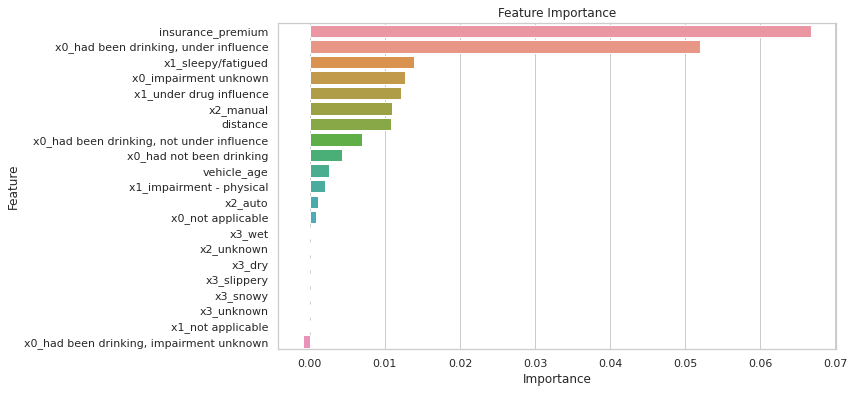

In [688]:
from sklearn.utils import resample

# Сэмплирование 1% тестовых данных
X_test_sample, y_test_sample = resample(X_test, y_test, n_samples=int(len(X_test) * 0.01), random_state=42)

# Трансформация тестовых данных
X_test_sample_transformed = randomized_search.best_estimator_.named_steps['preprocessor'].transform(X_test_sample)

# Расчёт permutation importance
result = permutation_importance(
    randomized_search.best_estimator_.named_steps['models'], 
    X_test_sample_transformed, y_test_sample, 
    scoring='roc_auc', n_repeats=5, n_jobs=-1
)

# Сортировка признаков по важности
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': result.importances_mean
}).sort_values('Importance', ascending=False)

# Построение графика
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance')
plt.show()

Важными факторами являются:<br>
    - страховка, т.к. чаще регистрируют ДТП<br> 
    - пьяный/трезвый водитель<br>
    - воздействие средств/лекарств<br>
    - сонное состояние, усталость<br>
    - тип КПП<br>
    - расстояние от главной дороги<br>
    - возраст машины<br>
    

Изучим влияние одного из факторов - **сонного состояния/усталости**.

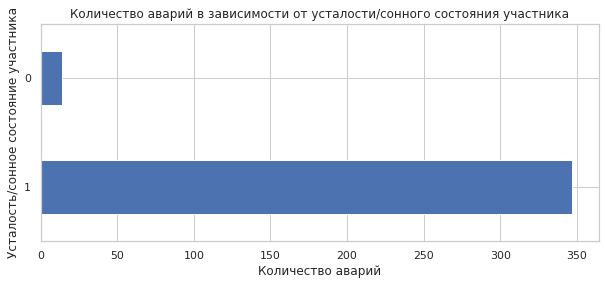

In [689]:
data[data['party_drug_physical']=='sleepy/fatigued']['at_fault'].value_counts().plot(y='Усталость/сонное состояние водителя',title='Количество аварий в зависимости от усталости/сонного состояния участника', kind='barh' , figsize = (10,4), legend = False)
plt.ylabel("Усталость/сонное состояние участника");
plt.xlabel("Количество аварий");

Видим, что в преобладающем большинстве случаев усталость и сонное состояние водителя приводит к авариям.

Для обнаружения такого состояния есть следующие устройства, которые можно внедрить в автомобиль:<br>
    - камеры с анализом лица<br>
    - устройства, измеряющие сердцебиение и стрессовое состояние водителя<br>
    - системы на основе датчиков в авто: сравнивают предыдущее вождение с нынешним, контролируют выход из полосы и странное поведение на дорогах<br>
    - мобильные приложения на смартфонах: отслеживает активность глаз.

## Выводы

### Общий анализ данных:<br>
Были изучены данные о ДТП.<br>
Данные содержат общую информацию о ДТП и об участниках ДТП, о пострадавших транспортных средствах.<br>
Целью исследования было:<br>
создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения. Под риском понимается вероятность ДТП с любым повреждением транспортного средства.<br>
Заказчиком выступила каршеринговая компания.


### Предобработка данных:
Были проанализированы 4 таблицы из БД, в них заменены неявные дубликаты и заполнены пропуски.<br>
В данных о клиентах магазина не было обнаружено явных дубликатов, неявные дубликаты скорректированы.<br>
Всего получилось 1 400 000 ДТП.


### Статистический анализ факторов ДТП:
Проанализировали **количество аварий**:<br>
В связи с тем, что данных, начиная с середины 2012 года, стало гораздо меньше, для анализа отобрали данные до 2012 года.<br>
Пики аварий приходятся на октябрь,  март и декабрь.<br>
Сильный всплеск значений в октябре возможно связан с первым снегом, гололедом на дорогах, когда не все участники движения успели переобуться.<br>
<br>
Составили **задачи для совещания рабочей группы**:
1. Выясните, в какое время суток происходит больше всего аварий.<br>
2. Проанализируйте, какие типы аварий бывают. Какую часть от всех происшествий на дороге составляют серьезные происшествия, а какую часть царапины, мелкие повреждения?<br>
3. При каких погодных условиях чаще всего возникают ДТП? Влияет ли погода на серьезность повреждения транспортного средства?<br>
4. Несет ли риск вождение "возрастного автомобиля"?<br>
5. Какая доля аварий происходит из-за использования телефона?<br>
6. Выяснить географию аварий: в каких странах, на каких типах дорог чаще всего происходят ДТП?<br>
<br>


Решили задачу **несет ли риски вождение возрастного автомобиля**<br>
Самая большая доля фатальных повреждений приходится на возрастные автомобили, которым более 15 лет.<br>
Т.е. определенный риск есть.<br>
Также большая доля "малых повреждений".<br>
У машин в категории 11-15 лет самая большая доля средних повреждений.

### Модель для оценки водительского риска:
Подготовили набор данных на основе первичного предположения заказчика:<br>
    - Выбрали тип виновника — только машина (car).<br>
    - Взяли случаи, когда ДТП привело к любым значимым повреждениям автомобиля любого из участников — все, кроме типа SCRATCH (царапина).<br>
    - Для моделирования взяли данные только за 2012 год.<br>
    - Отобрали машины не старше 10 лет<br>
    
Отобрали факторы. Для построения модели точно понадобятся:<br>
    - party_sobriety, т.е. трезвость участника<br>
    - party_drug_physical, т.е. состояние участника: физическое или с учётом принятых лекарств<br>
    - vehicle_age, т.е. возраст автомобиля (могут быть какие-то скрытые поломки, дефекты, что-то вышло из строя)<br>
    - road_surface, т.е. состояние дороги (т.к. на скользкой дороге машину может занести и водитель не справится с управлением)<br>
Также проверили факторы vehicle_transmission (тип КПП), insurance_premium (страховка) - это скорее фактор, как часто регистрируется ДТП, distance (расстояние от главной дороги).<br>

Произвели статистический анализ факторов. Явных аномалий выявлено не было (кроме колонки distance). Мультиколлинеартности не наблюдаем. Прослеживается связь между виновностью в аварии и фактором "трезвость водителя".
    
### Выбор лучшей модели:
К данным применили методы масштабирования и кодирования(OneHotEncoder).<br>
Применяли модели:<br>
    - KNeighborsClassifier с параметром n_neighbors<br>
    - DecisionTreeClassifier с параметрами max_depth, max_features<br>
    - LogisticRegression с параметром C<br>
    - SVC с параметром kernel<br>
Использовали RandomizedSearchCV для подбора гиперпараметров моделей.<br>
<br>
Качество оценивали метрикой ROC_AUC.<br>
<br>
ROC_AUC выбрали, т.к.:<br>
    - она учитывает работу модели при всех возможных значениях порогов<br>
    - объектов с одним значением целевого признака больше, чем с другими.
    
Наилучшей оказалась модель **логистической регресии** с параметрами C=4, penalty = l1. Метрика roc_auc на тестовой выборке составила 0,6975.

### Анализ важности признаков:
Важными факторами являются:<br>
    - пьяный/трезвый водитель<br>
    - воздействие средств/лекарств<br>
    - сонное состояние, усталость<br>
    - тип КПП<br>
    - расстояние от главной дороги<br>
    - возраст машины<br>

Проанализируем один из факторов.<br>
Видим, что в преобладающем большинстве случаев усталость и сонное состояние водителя приводит к авариям.

Для обнаружения такого состояния есть следующие устройства, которые можно внедрить в автомобиль:<br>
    - камеры с анализом лица<br>
    - устройства, измеряющие сердцебиение и стрессовое состояние водителя<br>
    - системы на основе датчиков в авто: сравнивают предыдущее вождение с нынешним, контролируют выход из полосы и странное поведение на дорогах<br>
    - мобильные приложения на смартфонах: отслеживает активность глаз.
    
### Выводы:
Построили модель, которая оценивает риски стать виновным в ДТП.<br>
Модель дала метрику 0,6975 на тестовой выборке. <br>
Риски зависят от состояния водителя (пьяный/трезвый, воздействие вредств/лекарств, сонное состояние/усталость), от возраста машины, от отдаленности от главной дороги.<br>
Какие-то факторы можно отслеживать при выдаче авто, например, физическое состояние водителя. Это можно сделать при помощи камеры и специальных устройств. И позволит снизить риск ДТП.<br>
Для улучшения модели можно попробовать объединить некоторые категории в признаках, поработать/комбинировать/создать новые признаки.
